# Google Playstore Apps rating Prediction

In [1]:
# Import Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
#Load and Clean Data

df = pd.read_csv("googleplaystore.csv")

# Drop corrupted row and filter ratings
df.drop(index=10472, inplace=True)
df = df[df['Rating'] <= 5]

# Remove duplicates
df.drop_duplicates(inplace=True)

# Replace rare categories with 'OTHER'
cat_counts = df['Category'].value_counts()
rare_cats = cat_counts[cat_counts < 200].index
df['Category'] = df['Category'].apply(lambda x: 'OTHER' if x in rare_cats else x)

# Remove rows with inappropriate 'Content Rating'
df = df[~df['Content Rating'].isin(["Adults only 18+", "Unrated"])]

In [3]:
#Clean Columns

def parse_size(val):
    try:
        if isinstance(val, str):
            if val.endswith('k'):
                return float(val[:-1]) / 1024
            elif val.endswith('M'):
                return float(val[:-1])
        return np.nan
    except:
        return np.nan

df['Size'] = df['Size'].replace('Varies with device', np.nan)
df['Size'] = df['Size'].apply(parse_size)
df['Size'].fillna(df['Size'].mean(), inplace=True)

df['Installs'] = df['Installs'].str.replace(",", "", regex=False).str.replace("+", "", regex=False)
df['Installs'] = pd.to_numeric(df['Installs'], errors='coerce')

df['Price'] = df['Price'].str.replace("$", "", regex=False)
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

df['Reviews'] = df['Reviews'].replace('3.0M', '3000000.0')
df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')

df['Last Updated'] = pd.to_datetime(df['Last Updated'], errors='coerce')
df['year_updated'] = df['Last Updated'].dt.year
df['month_updated'] = df['Last Updated'].dt.month

df.dropna(inplace=True)

C:\Users\harsh\AppData\Local\Temp\ipykernel_10948\3684573011.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Size'].fillna(df['Size'].mean(), inplace=True)


In [4]:
#Encode Categorical Variables

le = LabelEncoder()
df['Category'] = le.fit_transform(df['Category'])
df['Type'] = le.fit_transform(df['Type'])
df['Content Rating'] = le.fit_transform(df['Content Rating'])
df['Genres'] = le.fit_transform(df['Genres'])

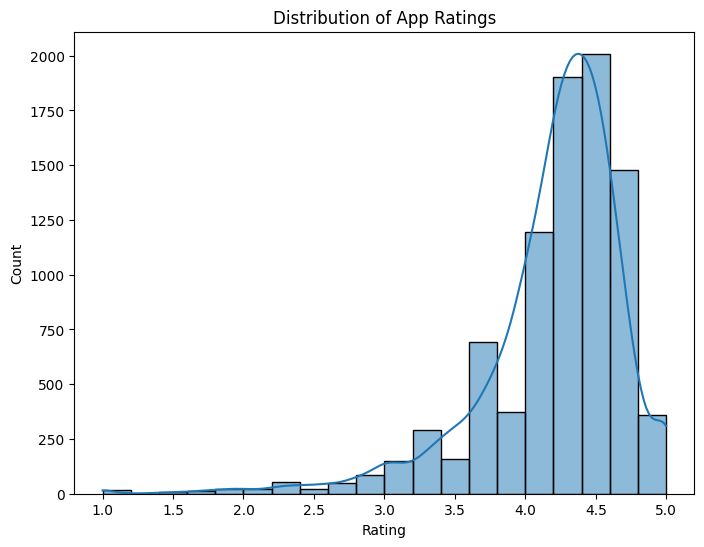

In [5]:
#Visualizations (EDA)
plt.figure(figsize=(8, 6))
sns.histplot(df['Rating'], bins=20, kde=True)
plt.title('Distribution of App Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

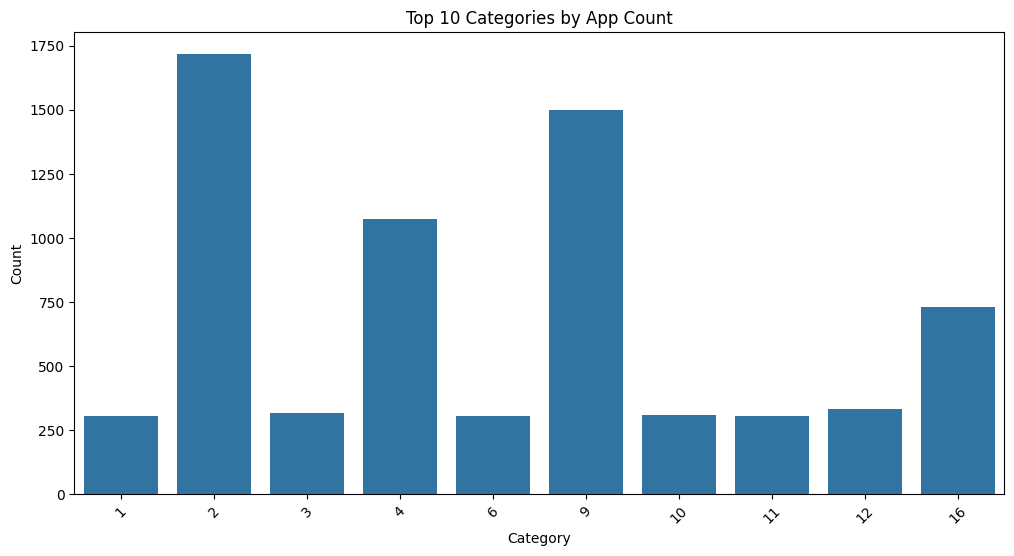

In [6]:
plt.figure(figsize=(12, 6))
top_cats = df['Category'].value_counts().head(10)
sns.barplot(x=top_cats.index, y=top_cats.values)
plt.title('Top 10 Categories by App Count')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

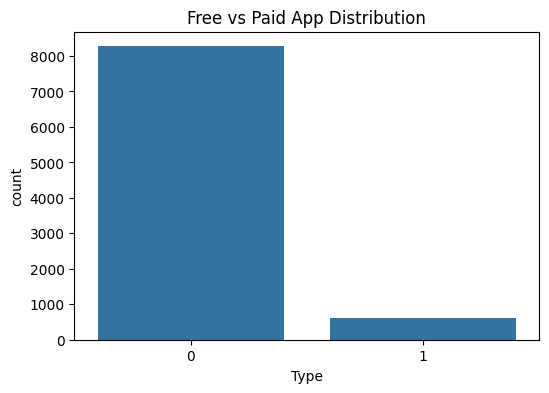

In [7]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Type')
plt.title('Free vs Paid App Distribution')
plt.show()

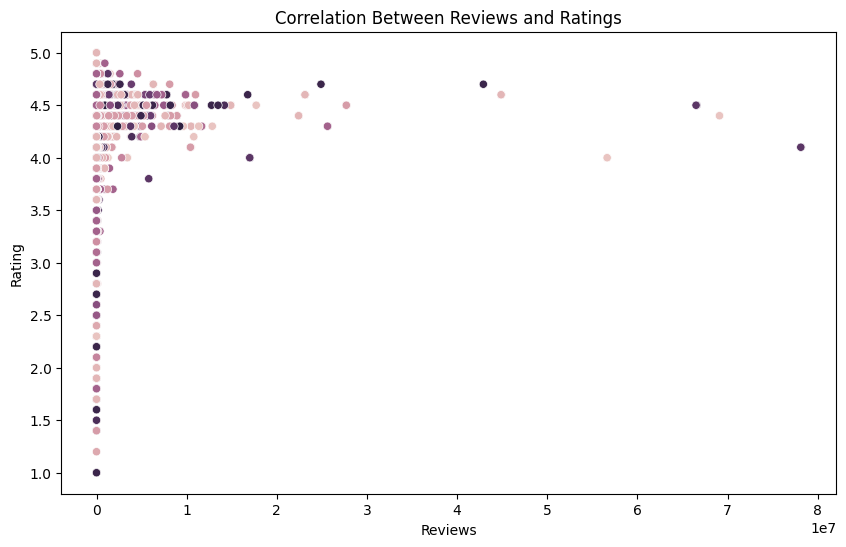

In [8]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Reviews', y='Rating', hue='Category', legend=False)
plt.title('Correlation Between Reviews and Ratings')
plt.show()

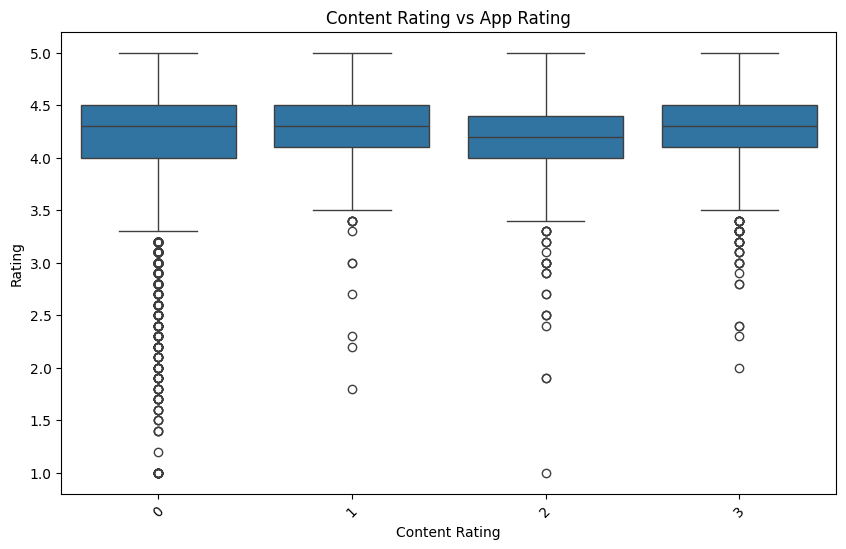

In [9]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Content Rating', y='Rating')
plt.title('Content Rating vs App Rating')
plt.xticks(rotation=45)
plt.show()

Top 10 Most Expensive Apps:
                                 App   Price  Rating
4367        I'm Rich - Trump Edition  400.00     3.6
4362                        I'm rich  399.99     3.8
5364  I am rich (Most expensive app)  399.99     4.1
5369                       I am Rich  399.99     4.3
4197          most expensive app (H)  399.99     4.3
5359              I am rich(premium)  399.99     3.5
5358                      I am Rich!  399.99     3.8
5356               I Am Rich Premium  399.99     4.1
5351                       I am rich  399.99     3.8
5373              I AM RICH PRO PLUS  399.99     4.0


C:\Users\harsh\AppData\Local\Temp\ipykernel_10948\725132628.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_expensive_apps, x='Price', y='App', palette='magma')


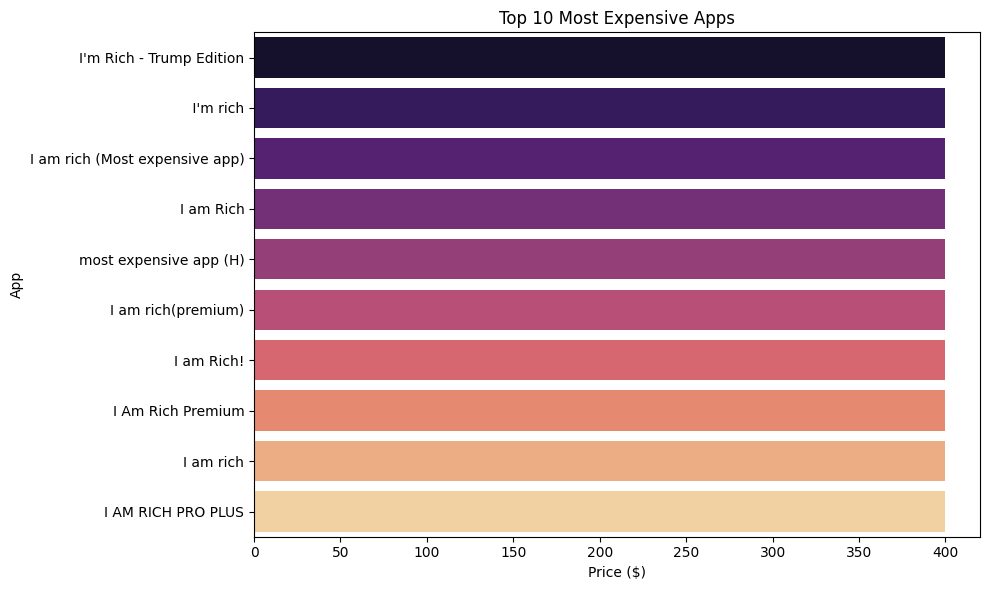

In [10]:
#Top 10 Expensive Apps

# Remove non-ASCII characters  from app names
df['App'] = df['App'].apply(lambda x: re.sub(r'[^\x00-\x7F]+', '', x))

top_expensive_apps = df[['App', 'Price', 'Rating']].sort_values(by='Price', ascending=False).head(10)

print("Top 10 Most Expensive Apps:")
print(top_expensive_apps)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_expensive_apps, x='Price', y='App', palette='magma')
plt.title('Top 10 Most Expensive Apps')
plt.xlabel('Price ($)')
plt.ylabel('App')
plt.tight_layout()
plt.show()


In [11]:
# Feature Prep and Scaling

X = df[['Category', 'Reviews', 'Size', 'Installs', 'Type', 'Price', 'Genres', 'Content Rating', 'year_updated', 'month_updated']]
y_class = df['Rating'].round().astype(int) - 1
y_reg = df['Rating']

scaler = MinMaxScaler()
X[['Reviews', 'Size', 'Installs', 'Price']] = scaler.fit_transform(X[['Reviews', 'Size', 'Installs', 'Price']])

C:\Users\harsh\AppData\Local\Temp\ipykernel_10948\3809667039.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['Reviews', 'Size', 'Installs', 'Price']] = scaler.fit_transform(X[['Reviews', 'Size', 'Installs', 'Price']])


In [12]:
#Classification

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, y_class, test_size=0.2, random_state=42)
sc = StandardScaler()
X_train_c = sc.fit_transform(X_train_c)
X_test_c = sc.transform(X_test_c)

clf = XGBClassifier(n_estimators=300, learning_rate=0.05, n_jobs=4, verbosity=0)
clf.fit(X_train_c, y_train_c)
print("XGBoost Classification Accuracy:", clf.score(X_test_c, y_test_c))

XGBoost Classification Accuracy: 0.7630838491840181


In [13]:
#Regression

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X, y_reg, test_size=0.2, random_state=42)
regressor = RandomForestRegressor(n_estimators=100, random_state=42)
regressor.fit(X_train_r, y_train_r)
y_pred_r = regressor.predict(X_test_r)
print("Random Forest Regression MSE:", mean_squared_error(y_test_r, y_pred_r))
print("Random Forest Regression R^2:", r2_score(y_test_r, y_pred_r))

Random Forest Regression MSE: 0.20369371680360154
Random Forest Regression R^2: 0.18154452485787442
